# Assignment 2

# Rain in Australia: Predict rain tomorrow in Australia
# Student Name: Sohail Sankanur
# Student ID: 29996368

Predicting Rain is a very common problem in machine learning. There can be different machine learning models which could be implemented for prediction of rain. In this assignment we are going to use some machine learning models to predict whether it would rain in the future based on some past features. 

In this assignment we are going to use the tools of machine learning to predict and visualise the possibility of rainfall in Australia.

As a initial task of the assignment we are importing all the libraries and functions which we would require in this assignment.

In [1]:
from collections import Counter 
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression

## Part A: Creating Spark Session and Loading the Data

In this part of the assignment we create a spark session and load the dataset which is given to us. Loading of the dataset is done using pyspark. We woule use the pyspark dataframe for all further programming.

### Step 01: Import Spark Session and initialize Spark

In this step we will be importing a library called pyspark. Pyspark is a python API for spark. In this we are going to use "SparkContext" which is a main entry for Spark functionality. We are also going to use "SparkConf" which is used for configuring Spark. Now our first step would be to import SparkContext and SparkConf libraries from pyspark

In [2]:
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

Now that we have imported the required libraries we now use this to create a Spark Session, initialize it and configure Spark to be used.

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Assignment2 Application")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.wk05_demo")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.wk05_demo")\
        .getOrCreate()

### Step 02: Load the dataset and print the schema and total number of entries

In this step we create a dataframe of the csv file data which is given to us. We can read the data from the csv file as a dataframe using pyspark. As seen we specify header as True which means that the first row of the data would be taken as a heading for all the columns in the dataframe.

In [4]:
# code to read the csv file using spark session
weather_df = spark.read.csv('weatherAUS.csv', header = True)

Now that we have read the data into a dataframe we now print the total number of entries in the dataframe. This can be done using the 'count' function in pyspark.

In [5]:
# code for printing the number of lines in the spark dataframe
weather_df.count()

142193

As seen from the above output there are 142193 entries in the dataframe.

## Part B: Data Cleaning and Processing

In this part of the assignment the dataset is cleaned and all the pre processing tasks is done on the dataset.

### Step 03: Delete columns from the dataset

In data cleaning we remove all unnecessary data from the dataset so that the accuracy of the model could be improved. Some columns from the dataset would not be required for prediction task. Hence in this step we delete certain columns from the dataset.
The columns which are being removed are:
* Date
* Location
* Evaporation
* Sunshine
* Cloud9am
* Cloud3pm
* Temp9am
* Temp3pm

In [6]:
weather_df.columns

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

Columns from the pyspark dataframe can be removed using the drop function. Inside the parameters which would be passed are the names of the columns which have to be dropped.

In [7]:
df_weather_modified = weather_df.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')

After dropping the unnecessary columns then new dataframe would have these set of columns.

In [8]:
weather_df.columns

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

### Step 04: Print the number of missing data in each column

In this step we have to print the **number of missing data in each column**.

As seen from the dataset and assignment specification we can see that the missing values in the dataset is **'NA'**. Hence we find the number of NA values in each column and print it out. 

We can find the number of 'NA' values in each column in the dataframe using the pyspark select function.

In [9]:
# code to find the number of na values in a column in the modified dataframe
df_weather_modified.select([count(when(df_weather_modified[c] == 'NA', c)).alias(c) for c 
                            in df_weather_modified.columns]).collect()


[Row(MinTemp=637, MaxTemp=322, Rainfall=1406, WindGustDir=9330, WindGustSpeed=9270, WindDir9am=10013, WindDir3pm=3778, WindSpeed9am=1348, WindSpeed3pm=2630, Humidity9am=1774, Humidity3pm=3610, Pressure9am=14014, Pressure3pm=13981, RainToday=1406, RainTomorrow=0)]

In an alternative way we can find the number of 'NA' values in each column by iterating through the columns. The code for this is as follows.

In [10]:
for i in df_weather_modified.columns:
    print('The number of empty rows in column ',i, ' is: ',df_weather_modified[df_weather_modified[i] == 'NA'].count())
    

The number of empty rows in column  MinTemp  is:  637
The number of empty rows in column  MaxTemp  is:  322
The number of empty rows in column  Rainfall  is:  1406
The number of empty rows in column  WindGustDir  is:  9330
The number of empty rows in column  WindGustSpeed  is:  9270
The number of empty rows in column  WindDir9am  is:  10013
The number of empty rows in column  WindDir3pm  is:  3778
The number of empty rows in column  WindSpeed9am  is:  1348
The number of empty rows in column  WindSpeed3pm  is:  2630
The number of empty rows in column  Humidity9am  is:  1774
The number of empty rows in column  Humidity3pm  is:  3610
The number of empty rows in column  Pressure9am  is:  14014
The number of empty rows in column  Pressure3pm  is:  13981
The number of empty rows in column  RainToday  is:  1406
The number of empty rows in column  RainTomorrow  is:  0


### Step 05: Fill the missing data with average value and maximum occurrence value

In this step you have to fill in all the missing data with average value (for numeric column) or maximum frequency value (for non-numeric column).

In this step we find the columns which have **numeric values**, calculate the average and fill the **null values with the average values**.

We also identify the **non numeric values** and in these columns we replace the **null values with the most frequent occuring item**.

Code for this would be as follows:

In [11]:
# code to remove all null values from the dataset
''' Rules for reoving the null values are:
    >> If the type is numeric then we replace all NA values with mean values
    >> If the type is non numeric then we replace all NA values with highest frequency term'''

df_weather_null = df_weather_modified

for i in df_weather_null.columns:
    if df_weather_null.select(i).head()[0].replace('.','').isdigit():
        df_weather_null = df_weather_null.withColumn(i, regexp_replace(i, 'NA', 
                           df_weather_modified.select(i).withColumn(i, df_weather_modified[i].cast(IntegerType())).
                            describe().collect()[1][1] ))
    else:
        df_weather_null = df_weather_null.withColumn(i, regexp_replace(i, 'NA', 
                            Counter(df_weather_modified.select(i).collect()).most_common(1)[0][0][0]))
    

### Step 06: Data transformation

In this step we need to transform the dataset so that it would be possible to process by machine learning. 

Firstly for non numeric data we have to use the **StringIndexer** function from pyspark to convert it into a number. Then we would typecast them to double format. For numeric columns we would directly typecast it into double format.

Code for this would be as follows:

In [12]:
df_weather_null_d = df_weather_null
for i in df_weather_null.columns:
    if df_weather_null.select(i).head()[0].replace('.','').isdigit():
        df_weather_null_d = df_weather_null_d.withColumn(i, df_weather_null_d[i].cast(DoubleType()))
    else:
        indexer = StringIndexer(inputCol=i, outputCol=i+'i').fit(df_weather_null_d)
        df_weather_null_d = indexer.transform(df_weather_null_d)
        df_weather_null_d  = df_weather_null_d.drop(i)
        df_weather_null_d = df_weather_null_d.withColumnRenamed(i+'i', i)

In [13]:
df_weather_null_d.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustSpeed', 'double'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('WindGustDir', 'double'),
 ('WindDir9am', 'double'),
 ('WindDir3pm', 'double'),
 ('RainToday', 'double'),
 ('RainTomorrow', 'double')]

As seen from the above output we can see that all the columns have the double format.

In [14]:
df_weather_null.head()

Row(MinTemp='13.4', MaxTemp='22.9', Rainfall='0.6', WindGustDir='W', WindGustSpeed='44', WindDir9am='W', WindDir3pm='WNW', WindSpeed9am='20', WindSpeed3pm='24', Humidity9am='71', Humidity3pm='22', Pressure9am='1007.7', Pressure3pm='1007.1', RainToday='No', RainTomorrow='No')

In [15]:
df_weather_null_d.head()

Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, WindGustSpeed=44.0, WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Pressure3pm=1007.1, WindGustDir=0.0, WindDir9am=6.0, WindDir3pm=7.0, RainToday=0.0, RainTomorrow=0.0)

As seen from the above output we can see that all the non numeric columns have been converted to double format numbers and all numeric columns have been converted to double format numbers as well.

### Step 07: Create the feature vector and divide the dataset

A feature vector can be defined as a vector which contains information describing the objects most important characteristics. In this step of the assignment we have to create a feature vector from the given columns. When we create a feature vector we have to remember to exclude the models which we would be using the test the accuracy of our model.

After creating the feature vecor we would divide the dataset into train data and test data. In machine learning we ususlly divide the dataset into 70% and 30%. 70% of the data would be the training data which would be used for training the machine learning model which we would build. The rest 30% of the data would be used as test dataset which would be used to test the accuracy of the model which we build.

#### Creating feature vector which could be used for machine learning

Now as the first task in this step we would make a vector column. This can be done using the VectorAssembler function of pyspark. As seen we give the input columns and the output column woule be the features column. Using this we make the feature column which is a vector which could be used in machine learning.

In [16]:
assembler = VectorAssembler(
    inputCols=["MinTemp", "MaxTemp", "Rainfall","WindGustSpeed",'WindSpeed9am','WindSpeed3pm','Humidity9am',
               'Humidity3pm','Pressure9am','Pressure3pm','WindGustDir','WindDir9am','WindDir3pm','RainToday'],
    outputCol="features")

df_weather_features = assembler.transform(df_weather_null_d)

In [17]:
df_weather_features.head()

Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, WindGustSpeed=44.0, WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Pressure3pm=1007.1, WindGustDir=0.0, WindDir9am=6.0, WindDir3pm=7.0, RainToday=0.0, RainTomorrow=0.0, features=DenseVector([13.4, 22.9, 0.6, 44.0, 20.0, 24.0, 71.0, 22.0, 1007.7, 1007.1, 0.0, 6.0, 7.0, 0.0]))

As seen from the output we can see that we have the vector column named as features.

#### Splitting the Data into training and testing datasets

The next task in this step would be to split the dataset into **training and testing dataset**. As seen the dataset is split into 70,30. Where in **70% of the dataset would be considered as the training data** which would be used to train the machine learning model and **30% of the dataset would be the testing data** which would be used for testing how the machine learning model would perform.

Usually in machine learning we would **train the model using the training data** and then we **perform predictions on the test data**. Now in the test dataset we would have the actual label values and the predicted label values. Using this we would compare the actual label vales and the value which was predicted and based on this we would see the accuracy of the model.

In [18]:
# dividing the dataset into training and testing datasets
# Split data into training (70%) and testing (30%)
seed = 0  # set seed for reproducibility
trainDF, testDF = df_weather_features.randomSplit([0.7,0.3], seed)

Now we have split the dataset into training and testing dataset. The number of rows in the train and test dataset would be as follows.

In [19]:
print("Number of training data: ", trainDF.count())
print("Number of test data: ", testDF.count())

Number of training data:  99799
Number of test data:  42394


## Part C: Apply Machine Learning Algorithms

In this part of the assignment we apply different machine learning on the dataset and compare their accuracy. As we can see this is a classification problem hence we would apply machine learning models which would perform classification.

The models whicha are going to apply on the dataset are:
* Decision Tree Classifier
* Random Forest Classifier
* Logistic Regression
* GBT Classifier

### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.

In this step we would apply classification machine learning models and compare the accuracy. The first model which we would apply to the dataset is Decision Tree Classifier. This can be done using the DecisionTreeClassifier method from the pyspark ml framework.

The model can be applied on the dataset using the fit method and using the transform method we would predict the values of the label column. The fit is done on the training dataset and the transform is done on the test dataset. code for this is as follows: 

### Model1: Decision Tree Classifier

In [20]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="RainTomorrow", featuresCol="features")
model = dt.fit(trainDF) # fitting the model with the training data
predictions_dt = model.transform(testDF) # performing the predictions on test data using the Decision 
                                         # Tree model which is create

Now that we have done the predictions we would see the accuracy of the model. Accuracy of the model is done with the help of the MulticlassClassificationEvaluator method of the pyspark evaluation library.

In [21]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions_dt)
dt_accuracy = accuracy*100
print("Accuracy of the Decision Tree Classifier model is: ", dt_accuracy)
print("Test Error = %g " % (1.0 - accuracy))

Accuracy of the Decision Tree Classifier model is:  82.00235971625308
Test Error = 0.179976 


As seen from the above output the accuracy of the Decision Tree Classifier model is around 82.

### Model2: Random Forest Classifier

Now we would use the Random Forest Classifier model. This can be done using the RandomForestClassifier methid of the pyspark ml library. Code for this is as follows:

In [22]:
rf = RandomForestClassifier(labelCol="RainTomorrow", featuresCol="features")
model = rf.fit(trainDF)
predictions_rf = model.transform(testDF)

Now that we have applied the RandomForest Classifier on the dataset we would find the accuracy of this model.

In [23]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions_rf)
rf_accuracy = accuracy*100
print("Accuracy of the Random Forest Classifier model is: ", accuracy*100)
print("Test Error = %g " % (1.0 - accuracy))

Accuracy of the Random Forest Classifier model is:  81.40446045082305
Test Error = 0.185955 


As seen from the above output the accuracy of the Random Forest Classifier model is around 81.

### Model3: Logistic Regression

The third model which we are going to use is the Logistic Regression Model. This can be done using the LogisticRegression method of the pyspark ml library.

In [24]:
lr = LogisticRegression(labelCol="RainTomorrow",featuresCol="features")
lrModel = lr.fit(trainDF)
predictions_lr = lrModel.transform(testDF)

trainingSummary = lrModel.summary
lr_accuracy = trainingSummary.accuracy * 100
print("Accuracy of the Logistic Regression Model is: ", lr_accuracy)

Accuracy of the Logistic Regression Model is:  83.72428581448712


We have applied the Logistic Regression model on the dataset. The logistic regression model would have summary and from the summary of the model we can see he accuracy of the model is around 84.

In [25]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_lr)
lr_accuracy = accuracy*100
print("Accuracy of the Logistic Regression model is: ", accuracy*100)
print("Test Error = %g " % (1.0 - accuracy))

Accuracy of the Logistic Regression model is:  84.05434731329905
Test Error = 0.159457 


Using the MulticlassClassificationEvaluator we can see that the accuracy of the model is around 84.

### Model4: GBT Classifier

The last model which we are going to apply on the data is the GBT Classifier model. This model is applied using the GBTClassifier method of the pyspark library. The code for using this model to train and perform predictions is as follows.

In [26]:
gbt = GBTClassifier(labelCol="RainTomorrow", featuresCol="features", maxIter=10)
model = gbt.fit(trainDF)
predictions_gbt = model.transform(testDF)


Now that we have applied the model we would see the accuracy of this model by using the MulticlassClassificationEvaluator method.

In [27]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_gbt)
gbt_accuracy = accuracy*100
print("Accuracy of the GBT Classifier model is: ", accuracy*100)
print("Test Error = %g " % (1.0 - accuracy))

Accuracy of the GBT Classifier model is:  84.1557767608624
Test Error = 0.158442 


As seen the accuracy of the model is around 84.

### Bar Plot Comparision of different models used for predictions

Now that we have the accuracy of all the models we would do a bar plot of the accuracy of all the models and compare them. The code for this is below.

<BarContainer object of 4 artists>

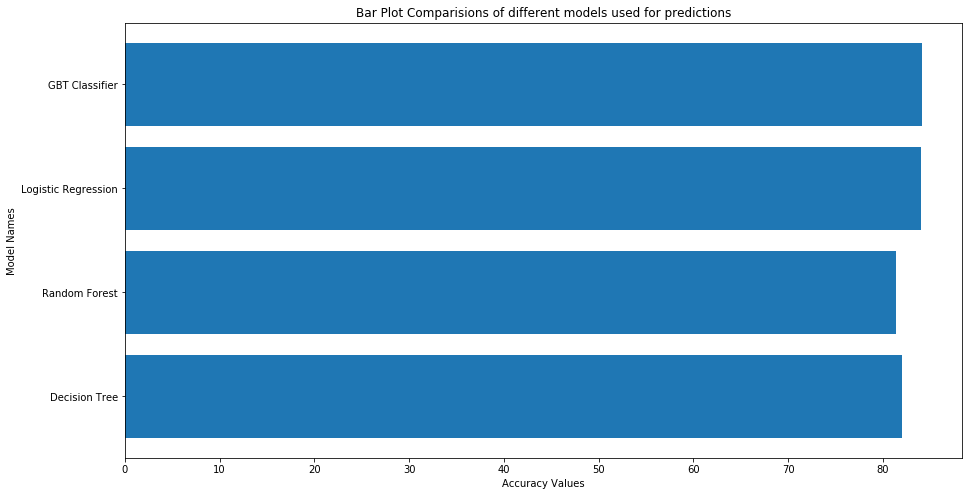

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,8))
accuracy_matrix = [dt_accuracy, rf_accuracy, lr_accuracy, gbt_accuracy]
model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'GBT Classifier']
plt.xlabel('Accuracy Values')
plt.ylabel('Model Names')
plt.title('Bar Plot Comparisions of different models used for predictions')
plt.barh(model_names, accuracy_matrix)

From the above plot we can see that the accuracy of all the four models is around the 80 to 85 range. Thus we can tell that all the four models are performing very good classification on the given dataset. However if a close comparision of all the models are done then we can see that the GBT Classifier model performs the best out of the given models.

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?

Now in this step we have to calculate the precession recall and F1 score for all the models which we have used for performing classification on the given dataset.

For doing this we would use the **confusion matrix**. The confusion matrix is considered as the most important metric. A confusion matrix is also known as the error matrix and this is a table which would be used for analysing the performance of an algorithm. Each row would represent instance of a predicted class and each column would represent instance of of an actual class. Using the confusion matrix we can calsulate other metrics such as precession, accuracy, recall and the F1 score of various models which we have used.

### Decision Tree Metrics

The confusion matrix of any model can be obtained using the confusionMatrix function of pyspark. 
The metrics for the Decision Tree model is as follows:

In [29]:
# Metrics for Decision Tree

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
predictionAndLabels = predictions_dt.select(['prediction', 'RainTomorrow'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(list))
confusion_mat = metrics.confusionMatrix()
print("Confusion Matrix")
print(confusion_mat.toArray())
# Overall statistics
f1Score = metrics.fMeasure()
print("\nSummary Stats")
print("Precision of Negative Class (RainTomorrow=False) is = %s" % metrics.precision(0))
print("Precision of Positive Class (RainTomorrow=True) is =  %s" % metrics.precision(1))
print("Recall of Negative Class (RainTomorrow=False) is =    %s" % metrics.recall(0))
print("Recall of Positive Class (RainTomorrow=True) is =     %s" % metrics.recall(1))
print("F1 Score = %s" % f1Score)

Confusion Matrix
[[31672.  1294.]
 [ 5547.  3881.]]

Summary Stats
Precision of Negative Class (RainTomorrow=False) is = 0.850963217711384
Precision of Positive Class (RainTomorrow=True) is =  0.749951690821256
Recall of Negative Class (RainTomorrow=False) is =    0.9607474367530182
Recall of Positive Class (RainTomorrow=True) is =     0.41164616037335594
F1 Score = 0.8386328253998208


The Precession, Recall and the F1Score can be found by another method. This is by using the confusion matrix values in the formulae. 

The formulae for Precession is given by:
* Precesion = (True Positive)/ (True Positive + False Positive)
* Recall = (True Positive)/ (True Positive + False Negative)
* F1 Score = 2 * (precesion * recall) / (precesion + recall)

In [30]:
cm_dt=confusion_mat.toArray()
precision_dt=(cm_dt[0][0])/(cm_dt[0][0]+cm_dt[1][0])
recall_dt=(cm_dt[0][0])/(cm_dt[0][0]+cm_dt[0][1])
f1_dt= 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)

print("The precision of the Decision Tree model is: ", precision_dt)
print("The Recall of the Decision Tree model is:" , recall_dt)
print("The f1 score of the Decision tree model is: ",f1_dt)

The precision of the Decision Tree model is:  0.850963217711384
The Recall of the Decision Tree model is: 0.9607474367530182
The f1 score of the Decision tree model is:  0.9025290304196053


### Random Forest Metrics

Now we find the metrics for the random forest classifier. The metrics for the random forest classifier is as follows:

In [31]:
# Confusion matrix for Random Forest

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
predictionAndLabels = predictions_rf.select(['prediction', 'RainTomorrow'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(list))
confusion_mat = metrics.confusionMatrix()
print("Confusion Matrix")
print(confusion_mat.toArray())
# Overall statistics
f1Score = metrics.fMeasure()
print("\nSummary Stats")
print("Precision of Negative Class (RainTomorrow=False) is = %s" % metrics.precision(0))
print("Precision of Positive Class (RainTomorrow=True) is =  %s" % metrics.precision(1))
print("Recall of Negative Class (RainTomorrow=False) is =    %s" % metrics.recall(0))
print("Recall of Positive Class (RainTomorrow=True) is =     %s" % metrics.recall(1))
print("F1 Score = %s" % f1Score)

Confusion Matrix
[[31945.  1021.]
 [ 5895.  3533.]]

Summary Stats
Precision of Negative Class (RainTomorrow=False) is = 0.8442124735729387
Precision of Positive Class (RainTomorrow=True) is =  0.7758014931927976
Recall of Negative Class (RainTomorrow=False) is =    0.969028696232482
Recall of Positive Class (RainTomorrow=True) is =     0.37473483241408573
F1 Score = 0.8368637071283672


Now using the formulae and from the confusion matrix we find the value for precession, recall and f1 score. This is done for the random forest model now. Code is as follows:

In [32]:
cm_rf=confusion_mat.toArray()
precision_rf=(cm_rf[0][0])/(cm_rf[0][0]+cm_rf[1][0])
recall_rf=(cm_rf[0][0])/(cm_rf[0][0]+cm_rf[0][1])
f1_rf= 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)

print("The precision of the Decision Tree model is: ", precision_rf)
print("The Recall of the Decision Tree model is:" , recall_rf)
print("The f1 score of the Decision tree model is: ",f1_rf)

The precision of the Decision Tree model is:  0.8442124735729387
The Recall of the Decision Tree model is: 0.969028696232482
The f1 score of the Decision tree model is:  0.902324661751829


### Logistic Regression Metrics

Now we find the metrics for the Logistic Regression classifier. The metrics for the logistic regression classifier is as follows:

In [33]:
# Confusion matrix for Logistic Regression

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
predictionAndLabels = predictions_lr.select(['prediction', 'RainTomorrow'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(list))
confusion_mat = metrics.confusionMatrix()
print("Confusion Matrix")
print(confusion_mat.toArray())
# Overall statistics
f1Score = metrics.fMeasure()
print("\nSummary Stats")
print("Precision of Negative Class (RainTomorrow=False) is = %s" % metrics.precision(0))
print("Precision of Positive Class (RainTomorrow=True) is =  %s" % metrics.precision(1))
print("Recall of Negative Class (RainTomorrow=False) is =    %s" % metrics.recall(0))
print("Recall of Positive Class (RainTomorrow=True) is =     %s" % metrics.recall(1))
print("F1 Score = %s" % f1Score)

Confusion Matrix
[[31248.  1718.]
 [ 5042.  4386.]]

Summary Stats
Precision of Negative Class (RainTomorrow=False) is = 0.8610636538991457
Precision of Positive Class (RainTomorrow=True) is =  0.7185452162516383
Recall of Negative Class (RainTomorrow=False) is =    0.9478857004186131
Recall of Positive Class (RainTomorrow=True) is =     0.46521001272804413
F1 Score = 0.8405434731329905


Now using the formulae and from the confusion matrix we find the value for precession, recall and f1 score. This is done for the logistic regression model now. Code is as follows:

In [34]:
cm_lr=confusion_mat.toArray()
precision_lr=(cm_lr[0][0])/(cm_lr[0][0]+cm_lr[1][0])
recall_lr=(cm_lr[0][0])/(cm_lr[0][0]+cm_lr[0][1])
f1_lr= 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr)

print("The precision of the Decision Tree model is: ", precision_lr)
print("The Recall of the Decision Tree model is:" , recall_lr)
print("The f1 score of the Decision tree model is: ",f1_lr)

The precision of the Decision Tree model is:  0.8610636538991457
The Recall of the Decision Tree model is: 0.9478857004186131
The f1 score of the Decision tree model is:  0.902391128566478


### GBT Classifier Metrics

Now we find the metrics for the gbt classifier. The metrics for the gbt classifier is as follows:

In [35]:
# Confusion Matrix for GBT Classifier

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
predictionAndLabels = predictions_gbt.select(['prediction', 'RainTomorrow'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(list))
confusion_mat = metrics.confusionMatrix()
print("Confusion Matrix")
print(confusion_mat.toArray())

# Overall statistics
f1Score = metrics.fMeasure()
print("\nSummary Stats")
print("Precision of Negative Class (RainTomorrow=False) is: %s" % metrics.precision(0))
print("Precision of Positive Class (RainTomorrow=True) is:  %s" % metrics.precision(1))
print("Recall of Negative Class (RainTomorrow=False) is =    %s" % metrics.recall(0))
print("Recall of Positive Class (RainTomorrow=True) is =     %s" % metrics.recall(1))
print("F1 Score = %s" % f1Score)

Confusion Matrix
[[31368.  1598.]
 [ 5119.  4309.]]

Summary Stats
Precision of Negative Class (RainTomorrow=False) is: 0.8597034560254337
Precision of Positive Class (RainTomorrow=True) is:  0.7294735060098189
Recall of Negative Class (RainTomorrow=False) is =    0.9515258144755202
Recall of Positive Class (RainTomorrow=True) is =     0.45704285108188375
F1 Score = 0.8415577676086239


Now using the formulae and from the confusion matrix we find the value for precession, recall and f1 score. This is done for the gbt classifier model now. Code is as follows:

In [36]:
cm_gbt=confusion_mat.toArray()
precision_gbt=(cm_gbt[0][0])/(cm_gbt[0][0]+cm_gbt[1][0])
recall_gbt=(cm_gbt[0][0])/(cm_gbt[0][0]+cm_gbt[0][1])
f1_gbt= 2 * (precision_gbt * recall_gbt) / (precision_gbt + recall_gbt)

print("The precision of the Decision Tree model is: ", precision_gbt)
print("The Recall of the Decision Tree model is:" , recall_gbt)
print("The f1 score of the Decision tree model is: ",f1_gbt)

The precision of the Decision Tree model is:  0.8597034560254337
The Recall of the Decision Tree model is: 0.9515258144755202
The f1 score of the Decision tree model is:  0.9032871150274286


Now that we have completed finding the accuracy and metrics for all the models we would now create a dataframe of model names along with the accuracy values. This would be as follows.

In [37]:
from pyspark.sql.types import *

cSchema = StructType([StructField("Model Names", StringType()),StructField("Accuacy Values", DoubleType())])

accuracy_matrix = [dt_accuracy, rf_accuracy, lr_accuracy, gbt_accuracy]
model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'GBT Classifier']
test_list = [list(x) for x in zip(model_names, accuracy_matrix)]

df = spark.createDataFrame(test_list,schema=cSchema) 

In [38]:
df.show()

+-------------------+-----------------+
|        Model Names|   Accuacy Values|
+-------------------+-----------------+
|      Decision Tree|82.00235971625308|
|      Random Forest|81.40446045082305|
|Logistic Regression|84.05434731329905|
|     GBT Classifier| 84.1557767608624|
+-------------------+-----------------+



As seen all the models have more or less the same values for accuracy. **However on very close comparision of accuracy and metrics we can say thay GBT Classifier is the best model for this data and for predicting the rainfall in australia.**

### How can we increase the accuracy of the model?

This is one of the most frequent questions which is asked in machine learning. However the answer for this is not straightforward and simple.

* There could be many ways of increasing the accuracy of a model. One of the best way would be to **get more data**. The more data we have the **more training data we would have and this means that the model would be more accurate and precise**. A more precise model would inturn lead to better accuracy.


* Also once we have huge amounts of data this does not mean that the accuracy is going to be better. We have to properly **preprocess** the given data. This means we have to **treat the missing values** for the data and all the **outliers** should be removed from the dataset. The outliers of a dataset could be removed using the boxplot technique.


* Also one of the things which we have to do before starting off with machine learning modelling is **feature engineering and feature selection**. A usual dataset would have many columns however all the columns would not be useful in machine learning prediction tasks. Hence we have to find out the best features which would be required for making the model and implementing machine learning algorithms.


* **Multiple Algorithms** have to be used for the best results.There are many models for classification technique and using just one model would not be a good way to proceed. For a certain dataset one machine learning model would be good however the same model might not be the best used for another type of data. Hence we have to experiment with multiple models and compare their accuracy and metrics to select the best model.


* We could also use **Parameter and Algorithm Tuning**. In some case if we fix the model however the accuracy is still not appriciable we could do parameter/algorithm tuning. In parameter tuning the parameter are tuned by a pyspark method so that the model would get better data and predictions would be more accurate. We can also tune the parameters of the model to achieve higher values of accuracy.


* The last way in which we could obtain higher values of accuracy is by **Ensemble methods**. We could use bagging and boosting methods to split the data in the right proportion and to achieve better results in machine learning.

### References:
* Spark Documentation - (https://spark.apache.org/docs/latest)
* https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/
* Monash Lectures and Tutorials